Import Required Libraries

In [99]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

Load MNIST dataset in train_set

In [100]:
train_set = torchvision.datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

)

In [101]:
print(train_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


Check total number of records/rows in dataset

In [102]:
len(train_set)

60000

In [103]:
train_set.train_labels

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

Check number of items/images in each label

In [104]:
train_set.train_labels.bincount()

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [105]:
sample = next(iter(train_set))
sample

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Extract images and labels from the sample data

In [106]:
mnist_image, mnist_label = sample

In [107]:
mnist_image.size()

torch.Size([1, 28, 28])

Print the image from the sample data

label:  5


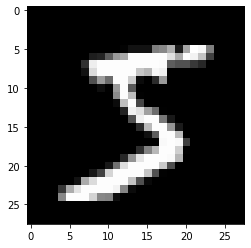

In [108]:
import matplotlib.pyplot as plt

plt.imshow(mnist_image.squeeze(), cmap='gray')
print('label: ', mnist_label)

Get the random number between 0 to 9

In [109]:
import random

random_number = random.randint(0,9)
print(random_number)

4


In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define Network

In [111]:
import torch.nn as nn

class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)  #This is conv layer-1 for mnist image
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5) #This is conv layer-2 for mnist image
    self.fc1 = nn.Linear(in_features=1, out_features=10)                  #This is fully connected layer for random number
    self.fc2 = nn.Linear(in_features=12 * 4 * 4, out_features=120)        #This is fully connected layer-1 for mnist image
    self.fc3 = nn.Linear(in_features=120, out_features=60)                #This is fully connected layer-2 for mnist image
    self.out = nn.Linear(in_features=60, out_features=10)                 #This is fully connected output layer for mnist image
  
  def forward(self, mnist_image, random_number):
    
    random_number = torch.tensor(random_number, dtype=torch.float).unsqueeze(dim=0)   #take the random number and convert that to tensor
    x = mnist_image
    
    # conv1 layer
    x = self.conv1(x) # 28 > 24
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12
    
    # conv2 layer
    x = self.conv2(x) # 12
    x = F.relu(x) # 8
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4
    
    # reshapre
    x = x.reshape(-1, 12 * 4 * 4)
    
    # fc1 layer for random number
    y = self.fc1(random_number)
    
    y = F.relu(y)
    
    # fc2 layer for mnist number
    x = self.fc2(x)
    x = F.relu(x)

    # fc3 layer
    x = self.fc3(x)
    x = F.relu(x)

    # output layer
    x = self.out(x)
    x = F.softmax(x, dim=1)
   
    y=y.view(1,10)
   
    #sum of 2 numbers (tensors)
    sum = x.add(y)  

    return x, sum

Print the network

In [112]:
network = Network()
network.to(device)
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=192, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


Define function to count number of correct images

In [113]:
def get_num_correct_images(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

Train the model for 12 epochs

In [114]:
import torch.nn.functional as F
import torch.optim as optim

network = Network()
network.to(device)

train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=16)

optimizer = optim.Adam(network.parameters(), lr=0.001)

for epoch in range(12):
  total_loss = 0
  total_correct = 0
  for newbatch in train_loader:
    images, labels = newbatch
    random_number = random.randint(0,9)
    
    preds, sum=network(images, random_number)
    loss = F.cross_entropy(preds.to(device), labels.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_correct += get_num_correct_images(preds,labels)

  accuracy = (total_correct*100)/len(train_set)
  print(
        "epoch:", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss,
        "accuracy:", str(round(accuracy, 2))+"%"
    )

epoch: 0 total_correct: 53918 loss: 5875.4244730472565 accuracy: 89.86%
epoch: 1 total_correct: 57787 loss: 5619.52460193634 accuracy: 96.31%
epoch: 2 total_correct: 58223 loss: 5590.693505764008 accuracy: 97.04%
epoch: 3 total_correct: 58447 loss: 5575.756269693375 accuracy: 97.41%
epoch: 4 total_correct: 58533 loss: 5570.622574925423 accuracy: 97.56%
epoch: 5 total_correct: 58572 loss: 5567.908988595009 accuracy: 97.62%
epoch: 6 total_correct: 58648 loss: 5563.639644503593 accuracy: 97.75%
epoch: 7 total_correct: 58656 loss: 5562.603075265884 accuracy: 97.76%
epoch: 8 total_correct: 58826 loss: 5552.839111566544 accuracy: 98.04%
epoch: 9 total_correct: 58780 loss: 5555.179874300957 accuracy: 97.97%
epoch: 10 total_correct: 58880 loss: 5549.132606506348 accuracy: 98.13%
epoch: 11 total_correct: 58729 loss: 5558.45803809166 accuracy: 97.88%


Test the Model with few different numbers

In [115]:
sample = next(iter(train_set))
sample2 = iter(train_set)
sample3=next(sample2)
sample4=next(sample2)
sample5=next(sample2)

label:  0


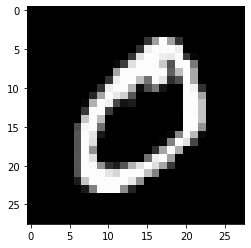

In [116]:
image4, label4 = sample4
plt.imshow(image4.squeeze(), cmap='gray')
print('label: ', label4)

In [117]:
random_number = random.randint(0,9)
print("random number: ", random_number)

preds, sum=network(image4, random_number)
number = preds.argmax(dim=1)
mnist_number = number.item()

print('mnist_number', mnist_number)

sum = sum.max()
sum = sum.item()

print("Sum of numbers:", sum)

random number:  4
mnist_number 0
Sum of numbers: 4.0502777099609375


label:  4


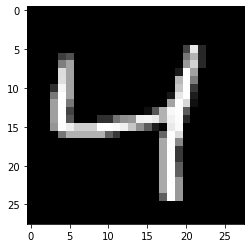

In [118]:
image5, label5 = sample5
plt.imshow(image5.squeeze(), cmap='gray')
print('label: ', label5)

In [122]:
random_number = random.randint(0,9)
print("random number: ", random_number)

preds, sum=network(image5, random_number)
number = preds.argmax(dim=1)
mnist_number = number.item()

print('mnist_number', mnist_number)

sum = sum.max()
sum = sum.item()

print("Sum of numbers:", sum)


random number:  1
mnist_number 4
Sum of numbers: 2.0643372535705566
